# 🏎️ F1 Monaco Race Lap Clustering Exploration
## Phase 3: Feature Discovery and Traffic Penalty Understanding
Author: Noora + Bestie Pit Wall 👩‍💻💖


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import fastf1
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
fastf1.Cache.enable_cache('/Users/nooralindeflaten/f1_ML_predictor/data/cache')

In [6]:
# Load Monaco laps dataset (already with DeltaLapTime, gaps, weather)
laps = pd.read_pickle('/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl')

# Optional: re-filter only race laps
laps = laps[laps['session_type'] == 'R'].copy()

# Clean GapToLeader, Interval columns
def clean_gap_value(val):
    if isinstance(val, str):
        if 'L' in val:
            return 90.0
        val = val.replace('+', '')
    try:
        return float(val)
    except:
        return None


laps['GapToLeader'] = laps['GapToLeader'].apply(clean_gap_value)
laps['IntervalToPositionAhead'] = laps['IntervalToPositionAhead'].apply(clean_gap_value)

# Drop missing
laps = laps.dropna(subset=['GapToLeader', 'IntervalToPositionAhead'])

print(laps.head())


                     Time_x Driver DriverNumber  LapTime  LapNumber  Stint  \
9454 0 days 00:09:29.267000    VET            5   78.447        2.0    1.0   
9455 0 days 00:10:47.355000    VET            5   78.088        3.0    1.0   
9456 0 days 00:12:04.843000    VET            5   77.488        4.0    1.0   
9457 0 days 00:13:22.670000    VET            5   77.827        5.0    1.0   
9458 0 days 00:14:39.991000    VET            5   77.321        6.0    1.0   

     PitOutTime PitInTime  Sector1Time  Sector2Time  ...  TrackTemp  \
9454        NaT       NaT       20.792       36.481  ...       33.7   
9455        NaT       NaT       20.519       36.460  ...       33.8   
9456        NaT       NaT       20.433       36.160  ...       33.9   
9457        NaT       NaT       20.582       36.320  ...       33.9   
9458        NaT       NaT       20.468       36.016  ...       33.6   

     WindDirection WindSpeed  year  round  session_type  \
9454           164       0.6  2018      6    

In [15]:
# train_cluster_tire_models.py

import pandas as pd
import joblib
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 🛞 CONFIG
INPUT_PATH = Path("/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl")
OUTPUT_FOLDER = Path("/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# 📚 Load processed Monaco dataset
laps = pd.read_pickle(INPUT_PATH)

# ✅ Only Race laps
laps = laps[laps['session_type'] == 'R'].copy()

# ✅ Make sure GapToLeader is cleaned
def clean_gap_value(val):
    if isinstance(val, str):
        if 'L' in val:
            return 90.0
        val = val.replace('+', '')
    try:
        return float(val)
    except:
        return None

laps['GapToLeader'] = laps['GapToLeader'].apply(clean_gap_value)
laps['IntervalToPositionAhead'] = laps['IntervalToPositionAhead'].apply(clean_gap_value)

# Drop NaNs in important columns
laps = laps.dropna(subset=['GapToLeader', 'IntervalToPositionAhead', 'TyreLife', 'LapTime', 'TrackTemp', 'AirTemp', 'Pressure'])

# 🏁 If no EnhancedCluster yet, create simple ones
if 'EnhancedCluster' not in laps.columns:
    from sklearn.cluster import KMeans
    features_for_clustering = laps[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead', 'TrackTemp', 'Pressure', 'Rainfall']].fillna(0)
    X = StandardScaler().fit_transform(features_for_clustering)
    kmeans = KMeans(n_clusters=4, random_state=42)
    laps['EnhancedCluster'] = kmeans.fit_predict(X)

# 🚗 Cluster Loop: Train one Tire Model per Cluster
for cluster_id in sorted(laps['EnhancedCluster'].unique()):
    print(f"🏎️ Training Tire Model for Cluster {cluster_id}")

    cluster_laps = laps[laps['EnhancedCluster'] == cluster_id].copy()

    if cluster_laps.shape[0] < 100:
        print(f"⚠️ Skipping cluster {cluster_id} (too few laps)")
        continue

        # 🛞 Fix Compounds (map old soft names to SOFT)
    def map_compound(compound):
        if compound in ['HYPERSOFT', 'ULTRASOFT', 'SUPERSOFT', 'SOFT']:
            return 'SOFT'
        elif compound == 'MEDIUM':
            return 'MEDIUM'
        elif compound == 'HARD':
            return 'HARD'
        else:
            return compound

    cluster_laps['MappedCompound'] = cluster_laps['Compound'].apply(map_compound)

    # Now one-hot encode MappedCompound instead of Compound
    cluster_laps = pd.get_dummies(cluster_laps, columns=['MappedCompound'])


    # 🎯 Define feature columns
    feature_cols = ['TyreLife', 'TrackTemp', 'AirTemp', 'Pressure', 'Rainfall']
    feature_cols += [col for col in cluster_laps.columns if col.startswith('MappedCompound_')]

    X = cluster_laps[feature_cols]
    y = cluster_laps['LapTime']

    # 📈 Train/Test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # 🚀 Model: Polynomial Regression
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linreg', LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    r2_score = pipeline.score(X_val, y_val)
    print(f"✅ Cluster {cluster_id} Tire Model R²: {r2_score:.4f}")

    # 💾 Save the model
    output = {
        'model': pipeline,
        'feature_names': feature_cols,
        'degree': 2,
        'cluster_id': cluster_id
    }

    save_path = OUTPUT_FOLDER / f"tire_model_cluster{cluster_id}.pkl"
    joblib.dump(output, save_path)
    print(f"💾 Saved to {save_path}")

print("🎉 DONE TRAINING ALL CLUSTER TIRE MODELS!")


🏎️ Training Tire Model for Cluster 0
✅ Cluster 0 Tire Model R²: 0.6006
💾 Saved to /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/tire_model_cluster0.pkl
🏎️ Training Tire Model for Cluster 1
✅ Cluster 1 Tire Model R²: 0.3190
💾 Saved to /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/tire_model_cluster1.pkl
🏎️ Training Tire Model for Cluster 2
✅ Cluster 2 Tire Model R²: 0.1806
💾 Saved to /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/tire_model_cluster2.pkl
🏎️ Training Tire Model for Cluster 3
✅ Cluster 3 Tire Model R²: 0.6416
💾 Saved to /Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/tire_model_cluster3.pkl
🎉 DONE TRAINING ALL CLUSTER TIRE MODELS!


/var/folders/t_/y1zy_tj51c35tggpc_c8twp40000gn/T/ipykernel_96533/3583902049.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['EnhancedCluster'] = kmeans.fit_predict(X)


In [72]:
# predict_laptime_from_clusters.py

import pandas as pd
import joblib
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy

# 🛞 CONFIG PATHS
LAPS_PATH = Path("/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl")
MODELS_FOLDER = Path("/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/")

# 📚 Load laps
laps = pd.read_pickle(LAPS_PATH)

# ✅ Same feature cleaning
        
def clean_gap_value(val):
    if isinstance(val, str):
        if 'L' in val:
            return 90.0
        val = val.replace('+', '')
    try:
        return float(val)
    except:
        return None

laps['GapToLeader'] = laps['GapToLeader'].apply(clean_gap_value)
laps['IntervalToPositionAhead'] = laps['IntervalToPositionAhead'].apply(clean_gap_value)

# Drop missing
laps = laps.dropna(subset=['GapToLeader', 'IntervalToPositionAhead', 'TyreLife', 'TrackTemp', 'AirTemp', 'Pressure'])

# 🚀 (Re)Cluster
features_for_clustering = laps[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead', 'TrackTemp', 'Pressure', 'Rainfall']].fillna(0)
X = StandardScaler().fit_transform(features_for_clustering)
kmeans = KMeans(n_clusters=4, random_state=42)
laps['EnhancedCluster'] = kmeans.fit_predict(X)

# 🛞 Load all cluster tire models
cluster_models = {}
for cluster_id in sorted(laps['EnhancedCluster'].unique()):
    model_path = MODELS_FOLDER / f"tire_model_cluster{cluster_id}.pkl"
    if model_path.exists():
        cluster_models[cluster_id] = joblib.load(model_path)
        print(f"✅ Loaded Tire Model for Cluster {cluster_id}")
    else:
        print(f"⚠️ No model for Cluster {cluster_id}")

# 🛠️ FUNCTION: Predict LapTime from raw inputs
def predict_laptime(tyre_life, track_temp, air_temp, pressure, rainfall, compound="SOFT"):
    """
    Predict LapTime based on inputs
    """
    # 🔍 Build feature set for clustering
    clustering_features = pd.DataFrame([{
        'TyreLife': tyre_life,
        'GapToLeader': 0,  # Assume clean air when predicting
        'IntervalToPositionAhead': 0,
        'TrackTemp': track_temp,
        'Pressure': pressure,
        'Rainfall': rainfall
    }])

    # 🔍 Predict Cluster
    scaler = StandardScaler()
    scaler.fit(features_for_clustering)  # Fit scaler on race data
    clustering_features_scaled = scaler.transform(clustering_features)
    predicted_cluster = kmeans.predict(clustering_features_scaled)[0]
    print(f"🔮 Predicted Cluster: {predicted_cluster}")

    # 🛞 Get Model
    model_data = cluster_models.get(predicted_cluster)
    if model_data is None:
        raise ValueError(f"No tire model available for cluster {predicted_cluster}")

    model = model_data['model']
    feature_names = model_data['feature_names']

    # 🔥 Build input feature vector
    features = {
        'TyreLife': tyre_life,
        'TrackTemp': track_temp,
        'AirTemp': air_temp,
        'Pressure': pressure,
        'Rainfall': rainfall
    }

    # One-hot compounds
    for col in feature_names:
        if col.startswith('MappedCompound_'):
            if col.lower().endswith(compound.lower()):
                features[col] = 1
            else:
                features[col] = 0

    # Fill missing features
    for col in feature_names:
        if col not in features:
            features[col] = 0

    # 📈 Predict
    X_predict = pd.DataFrame([features])[feature_names]
    predicted_laptime = model.predict(X_predict)[0]

    return predicted_laptime

def simulate_stint(
    start_lap_life=1,
    stint_length=30,
    track_temp=30,
    air_temp=25,
    pressure=1010,
    rainfall=0,
    compound=None
):
    print("🏎️ Simulating Stint...")
    laptimes = []
    # convert from numpy object to int
    start_lap_life = int(start_lap_life)
    for lap_life in range(start_lap_life, start_lap_life + stint_length):
        laptime = predict_laptime(
            tyre_life=lap_life,
            track_temp=track_temp,
            air_temp=air_temp,
            pressure=pressure,
            rainfall=rainfall,
            compound=compound
        )
        laptimes.append(laptime)
        print(f"Lap {lap_life}: Predicted LapTime = {laptime:.3f} seconds")
    return laptimes
# 🎯 Example usage:

example_wer_tyre = laps[laps['Compound']=='WET'].iloc[3]
example_inter_tyre = laps[laps['Compound']=='INTERMEDIATE'].iloc[2]
example_soft_tyre = laps[laps['Compound']=='SOFT'].iloc[3]
example_hard_tyre = laps[laps['Compound']=='HARD'].iloc[0]
example_medium_tyre = laps[laps['Compound']=='MEDIUM'].iloc[0]

def print_example_lap(lap):
    print(lap)
    print(f"💡Lap: {lap['LapNumber']}, TyreLife: {lap['TyreLife']}, TrackTemp: {lap['TrackTemp']}, AirTemp: {lap['AirTemp']}, Pressure: {lap['Pressure']}, Rainfall: {lap['Rainfall']}, Compound: {lap['Compound']}")

def example_simulation_run(lap,rainfall=0):
    # Simulate a stint with the given lap
    print_example_lap(lap)
    example_simulation = simulate_stint(
        start_lap_life=1,
        stint_length=30,
        track_temp=lap['TrackTemp'],
        air_temp=lap['AirTemp'],
        pressure=lap['Pressure'],
        rainfall=rainfall,
        compound=lap['Compound']
    )
print(example_inter_tyre['year'])
print_example_lap(example_inter_tyre)

✅ Loaded Tire Model for Cluster 0
✅ Loaded Tire Model for Cluster 1
✅ Loaded Tire Model for Cluster 2
✅ Loaded Tire Model for Cluster 3
2022
Time_x                         0 days 02:10:45.177000
Driver                                            VER
DriverNumber                                        1
LapTime                                       105.603
LapNumber                                         3.0
Stint                                             2.0
PitOutTime                                        NaT
PitInTime                                         NaT
Sector1Time                                    28.867
Sector2Time                                    48.671
Sector3Time                                    28.065
Sector1SessionTime             0 days 02:09:28.491000
Sector2SessionTime             0 days 02:10:17.162000
Sector3SessionTime             0 days 02:10:45.227000
SpeedI1                                         128.0
SpeedI2                                         1

/var/folders/t_/y1zy_tj51c35tggpc_c8twp40000gn/T/ipykernel_96533/226739863.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps['EnhancedCluster'] = kmeans.fit_predict(X)


In [43]:
# simulate_stint_predictor.py

import pandas as pd
import joblib
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# 🛞 CONFIG PATHS
LAPS_PATH = Path("/Users/nooralindeflaten/f1_ML_predictor/data/processed/laps_with_weather_gaps_monaco.pkl")
MODELS_FOLDER = Path("/Users/nooralindeflaten/f1_ML_predictor/models/monaco_simulation/cluster_tire_models/")

# 📚 Load laps
laps = pd.read_pickle(LAPS_PATH)

# ✅ Basic cleaning
def clean_gap_value(val):
    if isinstance(val, str):
        if 'L' in val:
            return 90.0
        val = val.replace('+', '')
    try:
        return float(val)
    except:
        return None
# 🛠️ Tire compound fix
def map_compound(compound):
    """
    Map raw compound names into standardized ones.
    """
    if compound in ['HYPERSOFT', 'ULTRASOFT', 'SUPERSOFT', 'SOFT']:
        return 'SOFT'
    elif compound == 'MEDIUM':
        return 'MEDIUM'
    elif compound == 'HARD':
        return 'HARD'
    else:
        return compound

def sanitize_input_features(features: dict, feature_names: list) -> pd.DataFrame:
    """
    Sanitize input features to match model training format.
    Fill missing features and ensure correct dtype.
    """
    sanitized = {}
    for col in feature_names:
        sanitized[col] = features.get(col, 0)  # Fill missing with 0
    return pd.DataFrame([sanitized])[feature_names].astype('float64')
  
laps['GapToLeader'] = laps['GapToLeader'].apply(clean_gap_value)
laps['IntervalToPositionAhead'] = laps['IntervalToPositionAhead'].apply(clean_gap_value)
laps['Compound'] = laps['Compound'].apply(map_compound)

laps = laps.dropna(subset=['GapToLeader', 'IntervalToPositionAhead', 'TyreLife', 'TrackTemp', 'AirTemp', 'Pressure'])

# 🛞 Cluster setup
features_for_clustering = laps[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead', 'TrackTemp', 'Pressure', 'Rainfall']].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)
kmeans = KMeans(n_clusters=4, random_state=42)
laps['EnhancedCluster'] = kmeans.fit_predict(X_scaled)

# 🚀 Load tire models
cluster_models = {}
for cluster_id in sorted(laps['EnhancedCluster'].unique()):
    model_path = MODELS_FOLDER / f"tire_model_cluster{cluster_id}.pkl"
    if model_path.exists():
        cluster_models[cluster_id] = joblib.load(model_path)
        print(f"✅ Loaded Tire Model for Cluster {cluster_id}")



def predict_laptim(
    tyre_life,
    track_temp,
    air_temp,
    pressure,
    rainfall,
    compound="SOFT"
):
    """
    Predict LapTime using cluster tire models.
    """
    # 🛞 Step 1: Map compound name cleanly
    compound = map_compound(compound)

    # 🛞 Step 2: Cluster to find correct tire model
    clustering_features = pd.DataFrame([{
        'TyreLife': tyre_life,
        'GapToLeader': 0,
        'IntervalToPositionAhead': 0,
        'TrackTemp': track_temp,
        'Pressure': pressure,
        'Rainfall': rainfall
    }])

    clustering_features_scaled = scaler.transform(clustering_features)
    predicted_cluster = kmeans.predict(clustering_features_scaled)[0]
    print(f"🔮 Predicted Cluster: {predicted_cluster}")

    model_data = cluster_models.get(predicted_cluster)
    if model_data is None:
        raise ValueError(f"No tire model available for cluster {predicted_cluster}")

    model = model_data['model']
    feature_names = model_data['feature_names']

    # 🛞 Step 3: Build raw feature dict
    features = {
        'TyreLife': tyre_life,
        'TrackTemp': track_temp,
        'AirTemp': air_temp,
        'Pressure': pressure,
        'Rainfall': rainfall
    }
    # 🛞 Step 4: Add compound one-hot features
    for col in feature_names:
        if col.startswith('MappedCompound_'):
            if col.lower().endswith(compound.lower()):
                features[col] = 1
            else:
                features[col] = 0

    # 🛞 Step 5: Sanitize
    X_predict = sanitize_input_features(features, feature_names)

    # 🏎️ Step 6: Predict
    predicted_laptime = model.predict(X_predict)[0]

    # 🚑 Step 7: Clip crazy predictions
    predicted_laptime = max(predicted_laptime, 30)

    return predicted_laptime


# 🏁 Simulate Stint
def simulate_stint(
    start_lap_life=1,
    stint_length=30,
    track_temp=30,
    air_temp=25,
    pressure=1010,
    rainfall=0,
    compound="SOFT"
):
    print("🏎️ Simulating Stint...")
    laptimes = []
    for lap_life in range(start_lap_life, start_lap_life + stint_length):
        laptime = predict_laptim(
            tyre_life=lap_life,
            track_temp=track_temp,
            air_temp=air_temp,
            pressure=pressure,
            rainfall=rainfall,
            compound=compound
        )
        laptimes.append(laptime)
        print(f"Lap {lap_life}: Predicted LapTime = {laptime:.3f} seconds")
    return laptimes

# 🚦 Example: simulate a dry stint
example = laps.iloc[1]
example_laptimes = simulate_stint(
    start_lap_life=example['TyreLife'],
    stint_length=30,
    track_temp=example['TrackTemp'],
    air_temp=example['AirTemp'],
    pressure=example['Pressure'],
    rainfall=0,
    compound='SOFT'
)

print(f"🏁 Stint Simulated! Average LapTime: {sum(example_laptimes)/len(example_laptimes):.3f} seconds")


✅ Loaded Tire Model for Cluster 0
✅ Loaded Tire Model for Cluster 1
✅ Loaded Tire Model for Cluster 2
✅ Loaded Tire Model for Cluster 3
🏎️ Simulating Stint...


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [10]:
features = laps[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead', 'TrackTemp', 'Pressure', 'Rainfall']]

# Optional: standardize features so KMeans isn't biased
scaler = StandardScaler()
X = scaler.fit_transform(features)
# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
laps['EnhancedCluster'] = kmeans.fit_predict(X)

# See how many laps per cluster
print(laps['EnhancedCluster'].value_counts())



EnhancedCluster
2    2548
1    1665
0    1630
3    1138
Name: count, dtype: int64


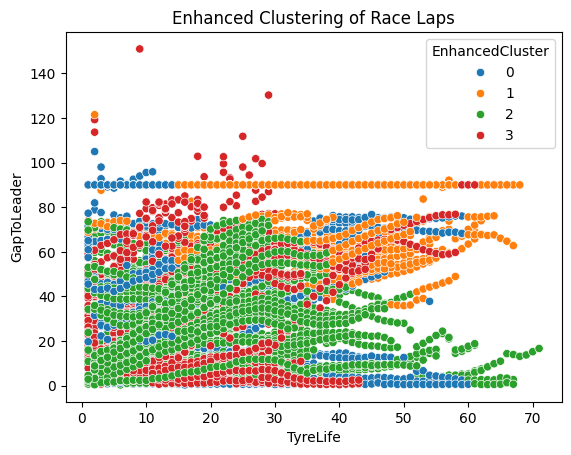

                  TyreLife  GapToLeader  TrackTemp    LapTime  Rainfall
EnhancedCluster                                                        
0                19.489571    40.536533  32.067730  83.988008  1.000000
1                28.926727    82.047365  34.334955  80.142322  0.060661
2                20.369309    30.543202  37.168093  78.896673  0.000000
3                17.760105    41.597858  28.453076  91.618522  0.383128


In [13]:
sns.scatterplot(data=laps, x='TyreLife', y='GapToLeader', hue='EnhancedCluster', palette='tab10')
plt.title('Enhanced Clustering of Race Laps')
plt.show()

summary = laps.groupby('EnhancedCluster').agg({
    'TyreLife': 'mean',
    'GapToLeader': 'mean',
    'TrackTemp': 'mean',
    'LapTime': 'mean',
    'LapTime': 'mean',
    'Rainfall': 'mean',
})
print(summary)



Cluster
0    3671
1    2784
2     526
Name: count, dtype: int64


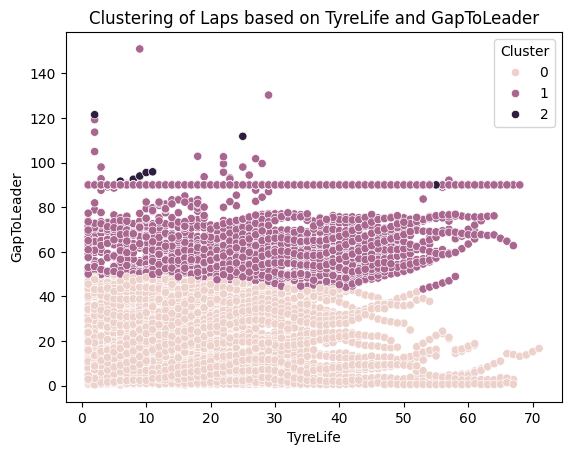

In [3]:
# Features for clustering
features = laps[['TyreLife', 'GapToLeader', 'IntervalToPositionAhead']]

# Fill NaNs (should already be clean but safe)
features = features.fillna(0)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
laps['Cluster'] = kmeans.fit_predict(features)

# How many in each cluster
print(laps['Cluster'].value_counts())

# Quick scatterplot
sns.scatterplot(data=laps, x='TyreLife', y='GapToLeader', hue='Cluster')
plt.title('Clustering of Laps based on TyreLife and GapToLeader')
plt.show()
